In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **MobileNet**

In [2]:
pip install --upgrade imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=84e66df38afa4ea8015f311a66914a32a2f81b91c1c08129d6995816ffb0b748
  Stored in directory: c:\users\geetad\appdata\local\pip\cache\wheels\85\cf\3a\e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Geetad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Geetad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


[INFO] loading images...
[INFO] compiling model...
[INFO] training head...


c:\Users\Geetad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
28/28 [==============================] - 48s 2s/step - loss: 2.2828 - accuracy: 0.5704 - val_loss: 0.9776 - val_accuracy: 0.6196
Epoch 2/50
28/28 [==============================] - 44s 2s/step - loss: 2.0683 - accuracy: 0.5608 - val_loss: 0.8388 - val_accuracy: 0.6913
Epoch 3/50
28/28 [==============================] - 44s 2s/step - loss: 1.8189 - accuracy: 0.6075 - val_loss: 0.7743 - val_accuracy: 0.7152
Epoch 4/50
28/28 [==============================] - 44s 2s/step - loss: 1.7069 - accuracy: 0.5968 - val_loss: 0.7273 - val_accuracy: 0.7326
Epoch 5/50
28/28 [==============================] - 44s 2s/step - loss: 1.5378 - accuracy: 0.6391 - val_loss: 0.6887 - val_accuracy: 0.7478
Epoch 6/50
28/28 [==============================] - 44s 2s/step - loss: 1.3986 - accuracy: 0.6577 - val_loss: 0.6526 - val_accuracy: 0.7609
Epoch 7/50
28/28 [==============================] - 45s 2s/step - loss: 1.2949 - accuracy: 0.6582 - val_loss: 0.6231 - val_accuracy: 0.7674
Epoch 8/50
28/28 [==

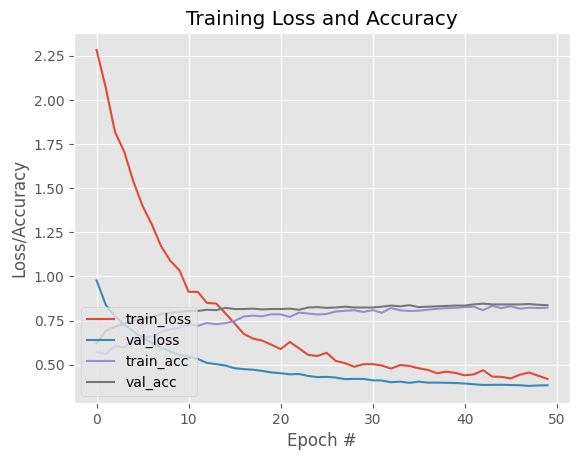

In [6]:
# import the necessary packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-5
EPOCHS = 50
BS = 64

DIRECTORY = r"D:data1a/training/"
DIRECTORY2=r"D:data1a/validation/"
CATEGORIES = ["00-damage", "01-whole"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)
        
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)



(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("MobileNet_Car_detection.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("MobileNet.png")

In [7]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
from keras import models    
MobileNet = models.load_model("MobileNet_Car_detection.model")

In [9]:
testURL="D:data1a/validation/"
damage_test_url="D:data1a/validation/00-damage/"
whole_test_url="D:data1a/validation/01-whole/"
damage_img = [f'{damage_test_url}/{i}' for i in os.listdir(damage_test_url)]
whole_img=[f'{whole_test_url}/{i}' for i in os.listdir(whole_test_url)]
total_img=damage_img+whole_img


1/1 [==============================] - 0s 54ms/step
Car is Damaged: 0.6830339, Car is not Damaged: 0.31696612
The car is damaged


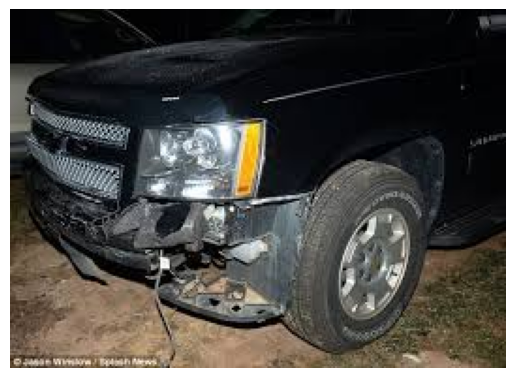

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:/data1a/validation/00-damage/0088.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

pred=MobileNet.predict(img_batch)
print("Car is Damaged: "+str(pred[0][0])+", Car is not Damaged: "+str(pred[0][1]))
if pred[0][0]<pred[0][1]:
    print("The car is not damaged")
else:
    print("The car is damaged")

# # **CNN** 

In [8]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
DIRECTORY = r"../input/car-damage-detection/data1a/training"
CATEGORIES = ["00-damage", "01-whole"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")



[INFO] loading images...


[INFO] compiling model...
[INFO] training head...


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
23/23 [==============================] - 18s 712ms/step - loss: 0.7194 - accuracy: 0.5319 - val_loss: 0.6866 - val_accuracy: 0.5380
Epoch 2/20
23/23 [==============================] - 17s 753ms/step - loss: 0.6926 - accuracy: 0.5143 - val_loss: 0.6867 - val_accuracy: 0.5788
Epoch 3/20
23/23 [==============================] - 16s 685ms/step - loss: 0.6866 - accuracy: 0.5523 - val_loss: 0.6802 - val_accuracy: 0.6033
Epoch 4/20
23/23 [==============================] - 17s 742ms/step - loss: 0.6793 - accuracy: 0.5516 - val_loss: 0.6752 - val_accuracy: 0.6005
Epoch 5/20
23/23 [==============================] - 16s 705ms/step - loss: 0.6776 - accuracy: 0.5802 - val_loss: 0.6601 - val_accuracy: 0.6277
Epoch 6/20
23/23 [==============================] - 18s 767ms/step - loss: 0.6745 - accuracy: 0.5815 - val_loss: 0.6550 - val_accuracy: 0.6223
Epoch 7/20
23/23 [==============================] - 16s 698ms/step - loss: 0.6723 - accuracy: 0.5815 - val_loss: 0.6461 - val_accuracy: 0.6413

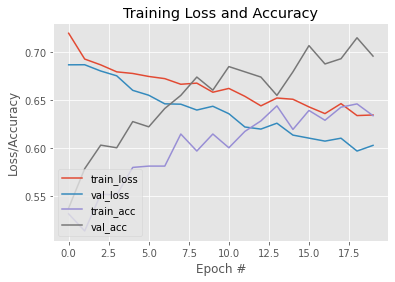

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
from keras.models import Sequential
from keras import layers

# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 64


model = Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu',
                    input_shape=(224,224,3),padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# place the head FC model on top of the base model (this will become
# the actual model we will train)
#model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("CNN_Car_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("CNN.png")

In [11]:
from keras import models    
CNN_Model = models.load_model("CNN_Car_detector.model")

Car is not Damaged: 1.0, Car is Damaged: 0.0
The car is not damaged


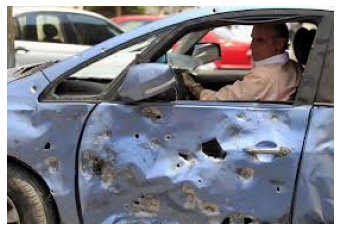

In [12]:
from tensorflow.keras.preprocessing import image
import cv2
img_path = "../input/car-damage-detection/data1a/validation/00-damage/0010.JPEG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

pred=CNN_Model.predict(img_batch)
print("Car is not Damaged: "+str(pred[0][0])+", Car is Damaged: "+str(pred[0][1]))
if pred[0][0]>pred[0][1]:
    print("The car is not damaged")
else:
    print("The car is damaged")
